<a href="https://colab.research.google.com/github/Antara999333/Antara/blob/main/Copy_of_Interpretable_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Duke-AI-XAI" # Change to your repo name
git_path = 'https://github.com/AIPI-590-XAI/Duke-AI-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [ ]:
pip install transformers datasets lime


In [ ]:
# Import necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from datasets import load_dataset
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch
import random

# Step 1: Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment', num_labels=5)  # Changed model for sentiment analysis

# Step 2: Set up the sentiment analysis pipeline using the pre-trained BERT model
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0)  # Removed disable_tqdm

# Step 3: Load the IMDb dataset directly from Hugging Face datasets
imdb_dataset = load_dataset('imdb', split='train[:100]')  # Only load the first 100 entries for testing
print(imdb_dataset[0])  # Show a sample entry from the dataset

# Step 4: Randomly pick a sample text for analysis and prediction
# Replace this with a specific index if you want to select a specific comment
random_index = random.randint(0, len(imdb_dataset) - 1)
sample_text = imdb_dataset[random_index]['text']
print(f"Sample review: {sample_text}")

# Step 5: Run sentiment analysis on the sample text
result = classifier(sample_text)
print(f"Sentiment prediction: {result}")

# Step 6: Define a function to use for LIME to predict probabilities
def predict_proba(texts):
    batch_size = 8  # Adjust the batch size as needed
    probabilities = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        results = classifier(batch_texts)

        for res in results:
            if res['label'] == 'LABEL_0':
                probabilities.append([1 - res['score'], res['score']])
            else:
                probabilities.append([res['score'], 1 - res['score']])

    return np.array(probabilities)

# Step 7: Initialize LIME explainer
explainer = LimeTextExplainer(class_names=["negative", "positive"])

# Step 8: Generate a local explanation for the sentiment prediction on the sample text
exp = explainer.explain_instance(sample_text, predict_proba, num_features=6)

# Step 9: Display the explanation in the notebook
exp.show_in_notebook(text=True)

# Optional: Save the explanation as an HTML file
exp.save_to_file('lime_explanation.html')



# VISUALIZATION OF EXPLANATION

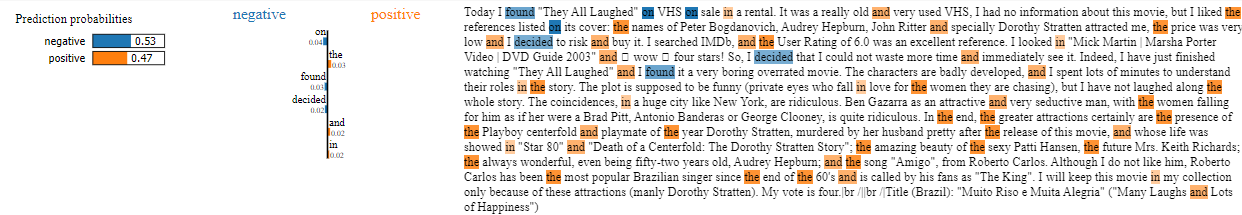

# RESULT

We can see that the model predicted the sentiment to be a bit more negative than positive. LIME also highlighted the words the words that were involved in making this decision and as provided their weights. The words were in,on,and,the,found and decided.

# WHY I CHOSE LIME
I chose LIME (Local Interpretable Model-agnostic Explanations) as the explanation technique for my sentiment analysis dataset from IMDb because of its model-agnostic nature, which allows it to generate explanations for the BERT model used for sentiment classification. This flexibility is very important when dealing with various input text since it highlights how specific words in movie reviews contribute to predictions of positive or negative sentiment.
Another great aspect would be that LIME provides localized explanations. It creates clarity on how models interpret language and make predictions based on context.

# LIMITATIONS
LIME can be sensitive to perturbations in a way that small modifications in the text may lead to inconsistent explanations. LIME also relies on sampling to create perturbed versions of the input, which can introduce variability and increase computational costs.

# IMPROVEMENTS
To improve my approach, I could explore using SHAP (SHapley Additive exPlanations) for comparison because it provides consistent feature importance scores that could lessen some variability that we might see with LIME.